In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Structured Data (From Module 1)
df_structured = pd.read_csv('../data/clinical_trials_clean.csv')

# 2. Load the NLP Data (From Module 2)
df_bert = pd.read_csv('../data/clinical_trials_with_bert.csv')

print(f"Structured Shape: {df_structured.shape}")
print(f"BERT Shape:       {df_bert.shape}")

# 3. Merge them on 'nct_id'
# We use 'inner' join to make sure we only keep trials that exist in both files
df_final = pd.merge(df_structured, df_bert, on=['nct_id', 'target'], how='inner')

print(f"Merged Shape:    {df_final.shape}")
display(df_final.head(3))

Structured Shape: (686, 12)
BERT Shape:       (686, 770)
Merged Shape:    (1874, 780)


,nct_id,study_type,start_date,completion_date,overall_status,phase,enrollment,sponsor_name,sponsor_type,condition_name,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,NCT06462118,INTERVENTIONAL,2024-06-17,2024-10-22,COMPLETED,PHASE1,78.0,"Genentech, Inc.",INDUSTRY,Healthy Volunteers,...,-0.260993,0.625437,0.315308,-0.226478,-0.092816,0.356996,0.476757,-0.409477,-0.442314,0.084519
1,NCT06312904,INTERVENTIONAL,2024-03-11,2024-08-14,COMPLETED,NaN,100.0,"Chinese Academy of Medical Sciences, Fuwai Hos...",OTHER,Postoperative Pain,...,-0.285322,0.678833,0.285818,-0.378346,0.041119,0.240173,0.337386,-0.300621,-0.498481,0.025284
2,NCT05505045,INTERVENTIONAL,2022-10-11,2024-04-04,COMPLETED,NaN,46.0,University of Missouri-Columbia,OTHER,Breast Cancer Female,...,-0.116789,0.640413,0.342753,-0.416973,-0.020761,0.256406,0.318534,-0.179768,-0.719305,-0.107027


In [2]:
# 1. Remove Duplicates (Keep the first entry for each trial)
df_final = df_final.drop_duplicates(subset=['nct_id'])
print(f"Shape after removing duplicates: {df_final.shape}")
# Should go back down to around 686

# 2. Handle Missing Values (Same as before)
df_final['phase'] = df_final['phase'].fillna('UNKNOWN')
df_final['enrollment'] = df_final['enrollment'].fillna(df_final['enrollment'].median())

# 3. Define Features
# We want: Enrollment + Encoded Sponsors/Phases + All 768 BERT columns
metadata_cols = ['enrollment', 'phase', 'sponsor_type']
bert_cols = [c for c in df_final.columns if 'bert_' in c] # Grabs bert_0 to bert_767

# 4. One-Hot Encode the Metadata
# We perform get_dummies on the whole dataframe
df_encoded = pd.get_dummies(df_final, columns=['phase', 'sponsor_type'], drop_first=True)

# 5. Prepare X and y
target = 'target'
# Drop non-math columns (ID, dates, names, raw text)
drop_cols = ['nct_id', 'study_type', 'start_date', 'completion_date', 'overall_status', 
             'sponsor_name', 'condition_name', 'target', 'text_feature'] 
# Note: 'text_feature' might not be there if you didn't save it, but 'condition_name' is.
# Safest way: Drop anything that isn't a number.

X = df_encoded.drop(columns=[c for c in drop_cols if c in df_encoded.columns])
y = df_encoded[target]

print(f"Ready for AI. X Shape: {X.shape}")

Shape after removing duplicates: (411, 780)
Ready for AI. X Shape: (411, 782)


In [3]:
from sklearn.model_selection import train_test_split

# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training on: {X_train.shape[0]} trials")
print(f"Testing on:  {X_test.shape[0]} trials")

Training on: 328 trials
Testing on:  83 trials


In [5]:
from xgboost import XGBClassifier

# 1. Calculate the ratio for the weight
# (Number of Successes / Number of Failures)
ratio = float(np.sum(y_train == 1)) / np.sum(y_train == 0)
print(f"Imbalance Ratio: {ratio:.2f} (We will weight failures this much more)")

# 2. Initialize the Model
model_xgb = XGBClassifier(
    scale_pos_weight=ratio,  # Fixes the imbalance
    n_estimators=100,        # Build 100 trees
    learning_rate=0.1,       # Learn step-by-step
    max_depth=4,             # Don't make trees too complex (prevents overfitting)
    random_state=42
)

# 3. Train
model_xgb.fit(X_train, y_train)
print("XGBoost Model Trained!")

Imbalance Ratio: 4.66 (We will weight failures this much more)
XGBoost Model Trained!


--- Hybrid Model (XGBoost + BioLinkBERT) Performance ---
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.93      1.00      0.96        68

    accuracy                           0.94        83
   macro avg       0.97      0.83      0.88        83
weighted avg       0.94      0.94      0.93        83

ROC-AUC Score: 0.9667


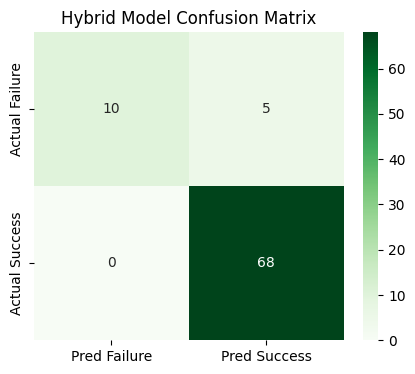

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Predict on the Test Set (The 83 hidden trials)
y_pred = model_xgb.predict(X_test)
y_probs = model_xgb.predict_proba(X_test)[:, 1] # Get probability scores (0 to 1)

# 2. Print the Report Card
print("--- Hybrid Model (XGBoost + BioLinkBERT) Performance ---")
print(classification_report(y_test, y_pred))

# 3. Calculate ROC-AUC (The 'Gold Standard' metric)
auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {auc:.4f}")

# 4. Visualize the Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Failure', 'Pred Success'],
            yticklabels=['Actual Failure', 'Actual Success'])
plt.title("Hybrid Model Confusion Matrix")
plt.show()

In [8]:
import shap

# 1. Initialize the Explainer
# We use TreeExplainer because XGBoost is a tree-based model
explainer = shap.TreeExplainer(model_xgb)

# 2. Calculate SHAP values (This might take 30-60 seconds)
# We only explain the Test Set to save time
shap_values = explainer.shap_values(X_test)

print("SHAP values calculated. Ready to visualize!")

SHAP values calculated. Ready to visualize!


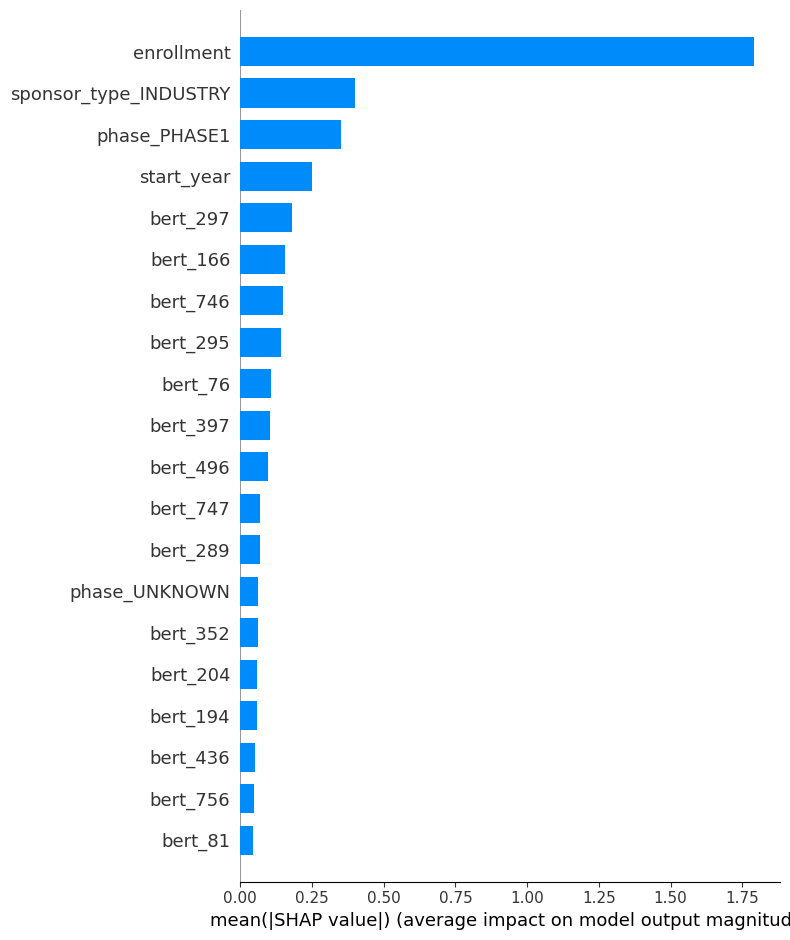

In [9]:
# Visualize the Top 20 Features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

In [10]:
import joblib

# 1. Save the Trained Model
joblib.dump(model_xgb, '../models/hybrid_xgboost.pkl')

# 2. Save the Column Names (Critical for the Dashboard!)
# The app needs to know that 'bert_0' comes after 'sponsor_type_NIH'
joblib.dump(X_train.columns.tolist(), '../models/model_columns.pkl')

print("Model and Feature List saved to ../models/")

Model and Feature List saved to ../models/
